# 2.3 ML models using Most Frequent Impute

In [2]:
#loading the train and test dataset
train = pd.read_csv("Train_imputed_most_frequent")
test = pd.read_csv("test_imputed_most_frequent")
y_train = pd.read_csv("y_train")
y_test = pd.read_csv("y_test")

In [3]:
train.drop(['Unnamed: 0'],axis = 1,inplace = True)
test.drop(['Unnamed: 0'],axis = 1,inplace = True)
y_train.drop(['Unnamed: 0'],axis = 1,inplace = True)
y_test.drop(['Unnamed: 0'],axis = 1,inplace = True)

In [4]:
train['class'] = y_train

In [5]:
#undersampling the negative class
train_neg_sampled = train[train['class'] == 0].sample(n = 10000,random_state = 42)
train_Sampled = train[train['class'] == 1].append(train_neg_sampled)

In [6]:
print("Shape of the train data after under sampling the negative class", train_Sampled.shape[0])

Shape of the train data after under sampling the negative class 11000


In [7]:
train_Sampled.head(3)

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
9,153204,182,0,0,0,0,0,0,11804,684444,...,26872,34044,22472,34362,0,0,0,0,0,1
23,453236,2926,0,0,0,0,0,222,323436,2999280,...,3026002,5025350,2025766,1160638,533834,493800,6914,0,0,1
60,72504,1594,1052,0,0,0,244,178226,1249396,3813464,...,372252,527514,358274,332818,284178,3742,0,0,0,1


In [8]:
y_train = train_Sampled['class']
train_Sampled.drop(['class'],axis = 1, inplace= True)

In [9]:
#Upsampling the positive class using smote technique to have a balanced dataset.
sm = over_sampling.SMOTE(ratio= 1.0)
train_Sampled_Smote, y_train = sm.fit_sample(train_Sampled,y_train)

In [10]:
print("Shape of train data after upsampling the positive class by smote", train_Sampled_Smote.shape)

Shape of train data after upsampling the positive class by smote (20000, 160)


In [11]:
#Standardizing the train and test data.
std = StandardScaler()
train_std = std.fit_transform(train_Sampled_Smote)
test_std = std.transform(test)


# 2.3.1 Logistic Regression

In [12]:
# model fitting and hyper parameter tuning using gridsearch
#weights = np.linspace(0.05, 0.95, 20)
params = {'C' : [
                10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3],
          'penalty': ['l1', 'l2']#,'class_weight': [{0: x, 1: 1.0-x} for x in weights]
         }

clf = LogisticRegression(n_jobs= -1,random_state=42)
clf.fit(train_std,y_train)
model = GridSearchCV(estimator=clf,cv = 2,n_jobs= -1,param_grid=params,scoring='f1',verbose= 2,)
model.fit(train_std,y_train)
print("Best estimator is", model.best_params_)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  32 | elapsed:   41.1s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   58.4s finished


Best estimator is {'C': 1000, 'penalty': 'l2'}


In [13]:
# model fitting using best parameter
clf = LogisticRegression(n_jobs= -1,random_state=42,C= 1000,penalty= 'l2')
clf.fit(train_std,y_train)
y_pred = clf.predict(test_std)
con_mat =confusion_matrix (y_test, y_pred)
print("-"*117)
print('Confusion Matrix: ', '\n',con_mat)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Confusion Matrix:  
 [[15274   351]
 [   35   340]]
---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  351
Type 2 error (False Negative) =  35
---------------------------------------------------------------------------------------------------------------------
Total cost =  21010
---------------------------------------------------------------------------------------------------------------------


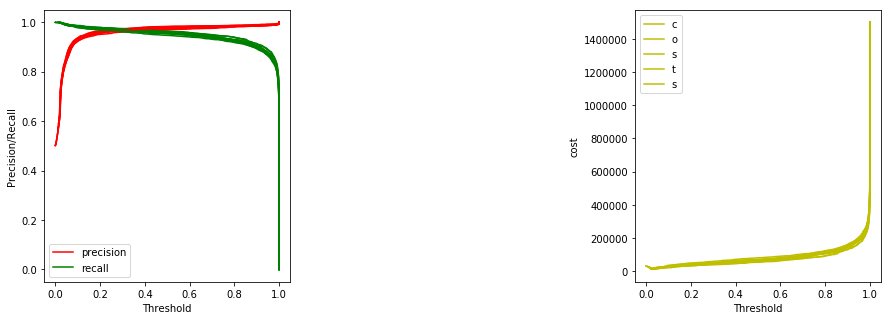

In [14]:
#CV for determining the best threshold
trail = 10
plot = []
for x in range(0,trail):
    train, test, y_tr, y_ts = train_test_split(train_std, y_train, stratify = y_train, train_size = 0.7)
    clf.fit(train,y_tr)
    pred = clf.predict_proba(test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_ts, pred)
    thresholds = np.append(thresholds,1)
      
    costs = []
    for threshold in thresholds:
        y_pred_thres = pred > threshold
        c = confusion_matrix(y_ts,y_pred_thres)
        cost = c[0,1] * 10 + c[1,0] * 500
        costs.append(cost)
        
    plot.append({'threshold': thresholds, 'precision':precision,'recall': recall, 'costs':costs})
    

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for x in plot:
    plt.plot(x['threshold'],x['precision'],'r')
    plt.plot(x['threshold'],x['recall'],'g')
    
plt.legend(('precision','recall'))
plt.xlabel('Threshold')
plt.ylabel("Precision/Recall")

plt.subplot(1,3,3)
for x in plot:
    plt.plot(x['threshold'],x['costs'],'y')
plt.legend(('costs'))
plt.xlabel('Threshold')
plt.ylabel("cost")
plt.show()

- At 0.2, we observe that precision is almost more than 95% and recall is almost around 98%. We want our recall to be near to 100% and at the same time we also want our precision to be high. 

In [15]:
# model fitting and prediciting using the best threshold
clf.fit(train_std,y_train)
y_pred_prob = clf.predict_proba(test_std)[:,1]  > 0.20
con_mat =confusion_matrix (y_test, y_pred_prob)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  665
Type 2 error (False Negative) =  21
---------------------------------------------------------------------------------------------------------------------
Total cost =  17150
---------------------------------------------------------------------------------------------------------------------


# 2.3.2 XgBoost

In [16]:
# model fitting and hyperparameter tunning using gridsearch
x_cfl=XGBClassifier()

prams={
    
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10]
}
model=GridSearchCV(x_cfl,param_grid=prams,verbose=10,n_jobs=-1,scoring='f1',cv=5)
model.fit(train_std,y_train)
print("Best estimator is", model.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed: 19.0min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed: 24.2min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 32.6min finished


Best estimator is {'max_depth': 10, 'n_estimators': 1000}


In [17]:
# model fitting using the best parameter
clf = XGBClassifier(max_depth= 10, n_estimators= 1000,n_jobs= -1)
clf.fit(train_std,y_train)
y_pred = clf.predict(test_std)
con_mat =confusion_matrix (y_test, y_pred)
print("-"*117)
print('Confusion Matrix: ', '\n',con_mat)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Confusion Matrix:  
 [[15389   236]
 [   33   342]]
---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  236
Type 2 error (False Negative) =  33
---------------------------------------------------------------------------------------------------------------------
Total cost =  18860
---------------------------------------------------------------------------------------------------------------------


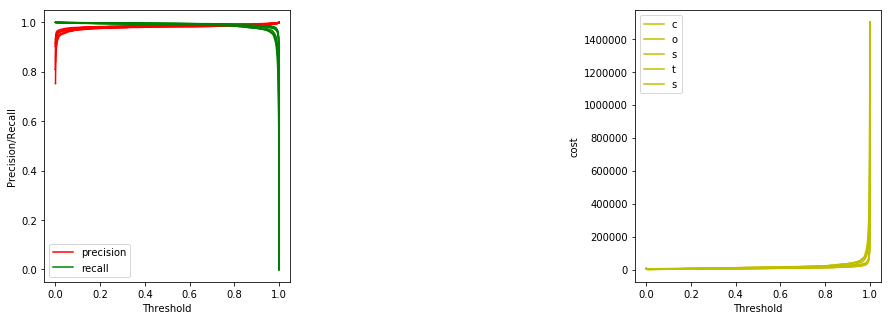

In [18]:
#CV to determine the best threshold
trail = 10
plot = []
for x in range(0,trail):
    train, test, y_tr, y_ts = train_test_split(train_std, y_train, stratify = y_train, train_size = 0.7)
    clf.fit(train,y_tr)
    pred = clf.predict_proba(test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_ts, pred)
    thresholds = np.append(thresholds,1)
      
    costs = []
    for threshold in thresholds:
        y_pred_thres = pred > threshold
        c = confusion_matrix(y_ts,y_pred_thres)
        cost = c[0,1] * 10 + c[1,0] * 500
        costs.append(cost)
        
    plot.append({'threshold': thresholds, 'precision':precision,'recall': recall, 'costs':costs})
    

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for x in plot:
    plt.plot(x['threshold'],x['precision'],'r')
    plt.plot(x['threshold'],x['recall'],'g')
    
plt.legend(('precision','recall'))
plt.xlabel('Threshold')
plt.ylabel("Precision/Recall")

plt.subplot(1,3,3)
for x in plot:
    plt.plot(x['threshold'],x['costs'],'y')
plt.legend(('costs'))
plt.xlabel('Threshold')
plt.ylabel("cost")
plt.show()

- At 0.25, we observe that precision is almost more than 95% and recall is almost around 98%. We want our recall to be near to 100% and at the same time we also want our precision to be high. 

In [19]:
# model fitting and predicting using the best threshold
clf.fit(train_std,y_train)
y_pred_prob = clf.predict_proba(test_std)[:,1]  > 0.25
con_mat =confusion_matrix (y_test, y_pred_prob)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  331
Type 2 error (False Negative) =  24
---------------------------------------------------------------------------------------------------------------------
Total cost =  15310
---------------------------------------------------------------------------------------------------------------------


# 2.3.3 Random Forest

In [20]:
# model fitting and hyperparameter tunning using gridsearch
x_cfl=RandomForestClassifier()
#weights = np.linspace(0.05, 0.95, 20)
prams={
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10]#,'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    
    
}
model=GridSearchCV(x_cfl,param_grid=prams,verbose=10,n_jobs=-1,scoring='f1',cv=5)
model.fit(train_std,y_train)
print("Best estimator is", model.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:  5.2min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:  7.0min remaining:   43.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  8.0min finished


Best estimator is {'max_depth': 10, 'n_estimators': 1000}


In [21]:
# model fitting using the best parameter
clf = RandomForestClassifier(n_estimators= 1000 , max_depth=10,n_jobs= -1)
clf.fit(train_std,y_train)
y_pred = clf.predict(test_std)
con_mat =confusion_matrix (y_test, y_pred)
print("-"*117)
print('Confusion Matrix: ', '\n',con_mat)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Confusion Matrix:  
 [[15192   433]
 [   12   363]]
---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  433
Type 2 error (False Negative) =  12
---------------------------------------------------------------------------------------------------------------------
Total cost =  10330
---------------------------------------------------------------------------------------------------------------------


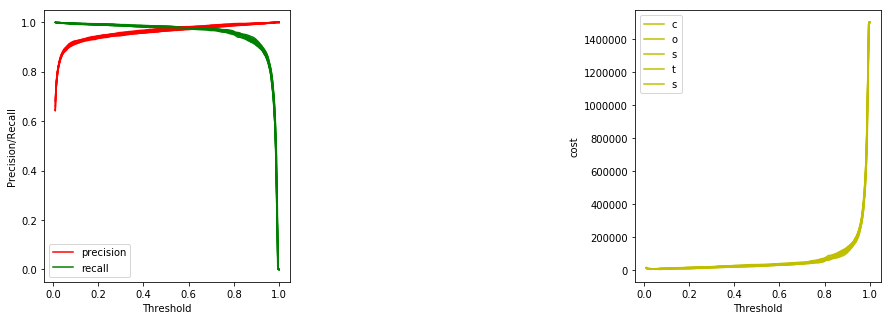

In [22]:
#CV for determining the best threshold
trail = 10
plot = []
for x in range(0,trail):
    train, test, y_tr, y_ts = train_test_split(train_std, y_train, stratify = y_train, train_size = 0.7)
    clf.fit(train,y_tr)
    pred = clf.predict_proba(test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_ts, pred)
    thresholds = np.append(thresholds,1)
      
    costs = []
    for threshold in thresholds:
        y_pred_thres = pred > threshold
        c = confusion_matrix(y_ts,y_pred_thres)
        cost = c[0,1] * 10 + c[1,0] * 500
        costs.append(cost)
        
    plot.append({'threshold': thresholds, 'precision':precision,'recall': recall, 'costs':costs})
    

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for x in plot:
    plt.plot(x['threshold'],x['precision'],'r')
    plt.plot(x['threshold'],x['recall'],'g')
    
plt.legend(('precision','recall'))
plt.xlabel('Threshold')
plt.ylabel("Precision/Recall")

plt.subplot(1,3,3)
for x in plot:
    plt.plot(x['threshold'],x['costs'],'y')
plt.legend(('costs'))
plt.xlabel('Threshold')
plt.ylabel("cost")
plt.show()

- At 0.2, we observe that precision is almost more than 95% and recall is almost around 98%. We want our recall to be near to 100% and at the same time we also want our precision to be high. 

In [26]:
#model fitting and predicting using the best threshold
clf.fit(train_std,y_train)
y_pred_prob = clf.predict_proba(test_std)[:,1]  > 0.20
con_mat =confusion_matrix (y_test, y_pred_prob)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  881
Type 2 error (False Negative) =  3
---------------------------------------------------------------------------------------------------------------------
Total cost =  10310
---------------------------------------------------------------------------------------------------------------------
